<div style="background-color:	#8844ee; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">Verhuuraantallen voorspellen</h1>
<b style="color:white">Tommi Lander, Casper de Knecht, Vera van veen</b>
    </div>


@misc{voorspel-verhuuraantallen-2023,
    author = {hoierik, Vikram Mark Radhakrishnan},
    title = {Voorspel verhuuraantallen 2023},
    publisher = {Kaggle},
    year = {2023},
    url = {https://kaggle.com/competitions/voorspel-verhuuraantallen-2023}
}

In deze opdracht voorspellen wij het aantal stuks dat per uur wordt verhuurd van een nog onbekend product. Na
afronding van deze opdracht krijgen wij te weten om welk product het gaat. 

Wij hebben een train en test dataset gekregen. 

De kolommen en wat erin staat:
- date_hour: Je hebt informatie over de periode van 1-1-2011 t/m 30-11-2012, nominaal
- holiday: Vakantiedag of geen vakantiedag, nominaal
- weathersit: Weersituatie, ordinaal: 
    1. Helder, licht bewolkt, deels bewolkt
    2. Mistig , mistig en licht bewolkt
    3. Lichte sneeuw, lichte regen, lichte regen en onweer, zwaar bewolkt, lichte regen en zwaar bewolkt
    4. Zware regen, hagel, zware mist, sneeuw.
- temp: genormaliseerde temperatuur, interval
- atemp: genormaliseerde gevoelstemperatuur, interval
- hum: genormaliseerde luchtvochtigheid, interval
- windspeed: genormaliseerde windsnelheid, interval

In de trainset staat de targetkolom 'cnt' hierin staat informatie over het aantal stuks dat per uur is
verhuurd.

Bij het train dataset gaan we de modellen trainen, testen en verbeteren. Het beste model met de beste parameters passen wij toe op de test dataset. 

In [1]:
#basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Fourier analysis
from scipy.fft import fft, ifft
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

#Regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

#metrics and CV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Exploratieve Data Analyse

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
display(train)
display(test)

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896
...,...,...,...,...,...,...,...
451,2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881
452,2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239
453,2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239
454,2012-12-19 22:00:00,0,1,0.34,0.3485,0.61,0.0896


In [3]:
display(train.info())
display(train.describe())
display(train.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


None

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


date_hour     0
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [4]:
display(test.info())
display(test.describe())
display(test.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   456 non-null    object 
 1   holiday     456 non-null    int64  
 2   weathersit  456 non-null    int64  
 3   temp        456 non-null    float64
 4   atemp       456 non-null    float64
 5   hum         456 non-null    float64
 6   windspeed   456 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 25.1+ KB


None

,holiday,weathersit,temp,atemp,hum,windspeed
count,456.0,456.000000,456.000000,456.000000,456.000000,456.000000
mean,0.0,1.592105,0.360132,0.363691,0.714868,0.157639
std,0.0,0.607882,0.079432,0.076354,0.177732,0.106499
min,0.0,1.000000,0.160000,0.181800,0.330000,0.000000
25%,0.0,1.000000,0.300000,0.303000,0.560000,0.089600
50%,0.0,2.000000,0.360000,0.363600,0.750000,0.134300
75%,0.0,2.000000,0.400000,0.409100,0.870000,0.223900
max,0.0,3.000000,0.600000,0.621200,1.000000,0.492500


date_hour     0
holiday       0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64

Er zitten geen missende waardes in de train dataset. Er zijn 4 kolommen die bestaan uit floats: 'temp', 'atemp', 'hum' en 'windspeed'. Er zijn 3 kolommen die integers zijn namelijk: 'holiday', 'weathersit' en 'cnt'. Er is maar 1 object en dat is de 'date_hour' kolom. Dus het voldoet aan de drie eisen van MachineLearning.
- Het is een DataFrame
- Er zitten geen missende waardes in.
- Alles in numeriek. Maar dat moet je wel de date_hour omzetten in een dateTime kolom.

In [5]:
train_plot = train.copy()
train_plot['date'] = pd.to_datetime(train_plot['date_hour'])
train_plot['day_of_week'] = train_plot['date'].dt.day_name()
train_plot['month'] = train_plot['date'].dt.month_name()
train_plot['year'] = train_plot['date'].dt.year
train_plot['hour'] = train_plot['date'].dt.hour
train_plot['Week'] = train_plot['date'].dt.isocalendar().week
train_plot

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,date,day_of_week,month,year,hour,Week
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,2011-01-01 00:00:00,Saturday,January,2011,0,52
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,2011-01-01 01:00:00,Saturday,January,2011,1,52
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2011-01-01 02:00:00,Saturday,January,2011,2,52
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,2011-01-01 03:00:00,Saturday,January,2011,3,52
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,2011-01-01 04:00:00,Saturday,January,2011,4,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,2012-11-30 19:00:00,Friday,November,2012,19,48
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,2012-11-30 20:00:00,Friday,November,2012,20,48
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,2012-11-30 21:00:00,Friday,November,2012,21,48
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,2012-11-30 22:00:00,Friday,November,2012,22,48


Hier maken we de dataframe train_plot aan. We maken twee verschillende dataframes aan omdat we dan in de train_plot de week dag en maand als woorden kunnen toevoegen, wat er beter uit ziet als we het gaan plotten. In Train_model zetten we deze waardes juist als nummer in de dataframe, want dan kunnen we er beter mee omgaan als we gaan modeleren.

In [6]:
train_model = train.copy()
train_model['date_hour'] = pd.to_datetime(train['date_hour'])

train_model['day_of_month'] = train_model['date_hour'].dt.day
train_model['day_of_week'] = train_model['date_hour'].dt.dayofweek
train_model['month'] = train_model['date_hour'].dt.month
train_model['year'] = train_model['date_hour'].dt.year
train_model['hour'] = train_model['date_hour'].dt.hour
train_model['Week'] = train_model['date_hour'].dt.isocalendar().week
train_model

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,day_of_month,day_of_week,month,year,hour,Week
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,1,5,1,2011,0,52
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,1,2011,1,52
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,1,5,1,2011,2,52
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,1,5,1,2011,3,52
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,1,5,1,2011,4,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,30,4,11,2012,19,48
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,30,4,11,2012,20,48
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,30,4,11,2012,21,48
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,30,4,11,2012,22,48


In [7]:
test_model = test.copy()
test_model['date_hour'] = pd.to_datetime(test['date_hour'])

test_model['day_of_month'] = test_model['date_hour'].dt.day
test_model['day_of_week'] = test_model['date_hour'].dt.dayofweek
test_model['month'] = test_model['date_hour'].dt.month
test_model['year'] = test_model['date_hour'].dt.year
test_model['hour'] = test_model['date_hour'].dt.hour
test_model['Week'] = test_model['date_hour'].dt.isocalendar().week
test_model

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,day_of_month,day_of_week,month,year,hour,Week
0,2012-12-01 00:00:00,0,1,0.26,0.3030,0.81,0.0000,1,5,12,2012,0,48
1,2012-12-01 01:00:00,0,1,0.26,0.3030,0.81,0.0000,1,5,12,2012,1,48
2,2012-12-01 02:00:00,0,2,0.26,0.3030,0.81,0.0000,1,5,12,2012,2,48
3,2012-12-01 03:00:00,0,2,0.26,0.2727,0.81,0.1343,1,5,12,2012,3,48
4,2012-12-01 04:00:00,0,1,0.26,0.2879,0.81,0.0896,1,5,12,2012,4,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,2012-12-19 19:00:00,0,1,0.38,0.3939,0.50,0.3881,19,2,12,2012,19,51
452,2012-12-19 20:00:00,0,1,0.36,0.3485,0.57,0.2239,19,2,12,2012,20,51
453,2012-12-19 21:00:00,0,1,0.34,0.3182,0.61,0.2239,19,2,12,2012,21,51
454,2012-12-19 22:00:00,0,1,0.34,0.3485,0.61,0.0896,19,2,12,2012,22,51


Om uiteindelijk de cnt te voorspellen voor de test dataset moeten we ervoor zorgen dat de test dataset en de train dataset er het zelfde uitzien. Anders kunnen we namelijk niet de waardes voorspellen.

**Bron**

Pandas.Series.dt.Dayofweek — Pandas 2.1.3 documentation. (z.d.). https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html

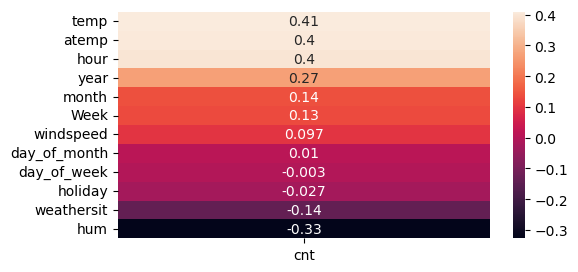

In [8]:
def corr_plot(df, target):
    """
    Plot de correlatieheatmap tussen kenmerken en de doelvariabele.

    Parameters:
    - df: DataFrame
        Het DataFrame met kenmerken en de doelvariabele.
    - target: str
        De naam van de doelvariabele.

    Returns:
    - None

    """
    fig, ax = plt.subplots(figsize=(6,3), dpi=100)
    sns.heatmap(df.corr()[[target]].drop([target]).sort_values(by=target, ascending=False), annot=True)

corr_plot(train_model, 'cnt')

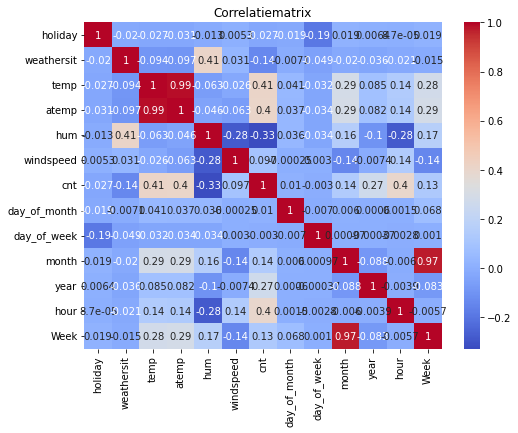

In [9]:
corr_matrix = train_model.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlatiematrix')
plt.show()

## **Visualisaties tijdreeks features**

In [10]:
def lineplot(data, x, y, hue=None):
    """
    Maakt een lijnplot.

    Parameters:
        
data : DataFrame
          De dataset die gebruikt wordt voor de plot.
x : str
        De naam van de kolom die op de x-as wordt weergegeven.
y : str
      De naam van de kolom die op de y-as wordt weergegeven.
hue : str, optioneel
    De naam van de kolom die gebruikt wordt om de lijnen te differentiëren (bijvoorbeeld kleur).

    Returns:
        None
    """
    sns.lineplot(data=data, x=x, y=y, hue=hue)

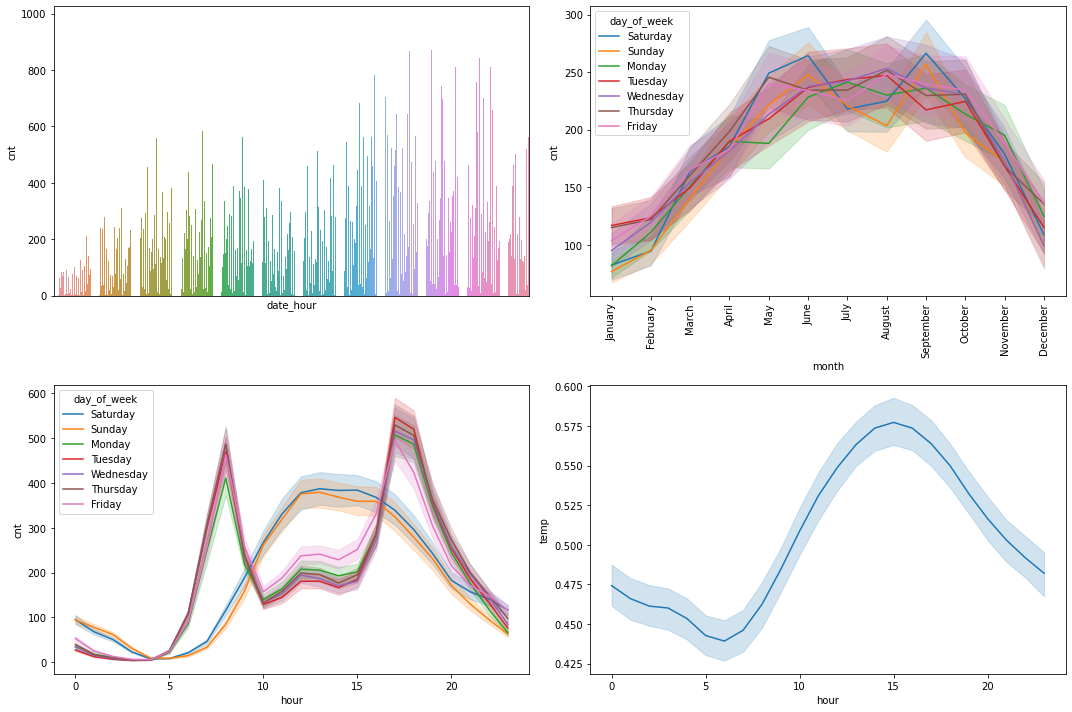

In [11]:

plt.figure(figsize=(15, 10))

# Plot 1
plt.subplot(2, 2, 1)  
sns.barplot(data=train_plot, x='date_hour', y='cnt')
plt.xticks([])  

# Plot 2
plt.subplot(2, 2, 2) 
lineplot(data=train_plot, x='month', y='cnt', hue='day_of_week')
plt.xticks(rotation=90)

# Plot 3
plt.subplot(2, 2, 3)  
lineplot(data=train_plot, x='hour', y='cnt', hue='day_of_week')

# Plot 4
plt.subplot(2, 2, 4)  
lineplot(data=train_plot, x='hour', y='temp')

plt.tight_layout()  
plt.show()


**Grafiek 1**

In de eerste grafiek zien wij als eerst dat het aantal wat verhuurd wordt steeds meer groeit, namelijk in begin van de barplot zien wij dat het vooral rond de 400 verhuurde exemplaren ligt, aan het einde van de barplot zijn dit er ongeveer 600. Daarnaast kunnen wij zien dat er veel pieken en dan ook weer dalingen zijn die snel richting de 0 verhuurde exemplaren gaan, dit zijn nachturen waar niks word verhuurd. 


**Grafiek 2**

In de tweede grafiek kijken we naar het aantal verhuurde exemplaren per maand. Hier zien wij dat er een piek ligt bij de maanden waar de zon schijnt en het minder koud is, richting de winter daalt de verhuur weer. Dit verteld ons dat seizoen erg veel invloed heeft.

**Grafiek 3**

In de derde grafiek zien wij het aantal verhuurde exemplaren ten opzichte van de uren. Hierin zien we ook de dagen van de week en kunnen wij dus goed zien op welk tijdstip fietsen worden verhuurd. Wat ons direct opvalt is zijn de twee pieken die rond 8 uur 's ochtends en 5 uur 's avonds liggen, en dat vooral op de doordeweekse dagen. Dit laat ons zien dat waarschijnlijk mensen dit product gebruiken voor en na werk bijvoorbeeld vervoer. Ook zien wij een langdurige minder hoge piek, wat in het weekend is. Dit product word dus ook gebruikt in het weekend voor plezier en / of vervoer. 

**Grafiek 4**

In de grafiek 4 zien we de temperatuur gedurende de uren. Opmerkelijk is dat deze sterk lijkt op de lijn van de weekenddagen.

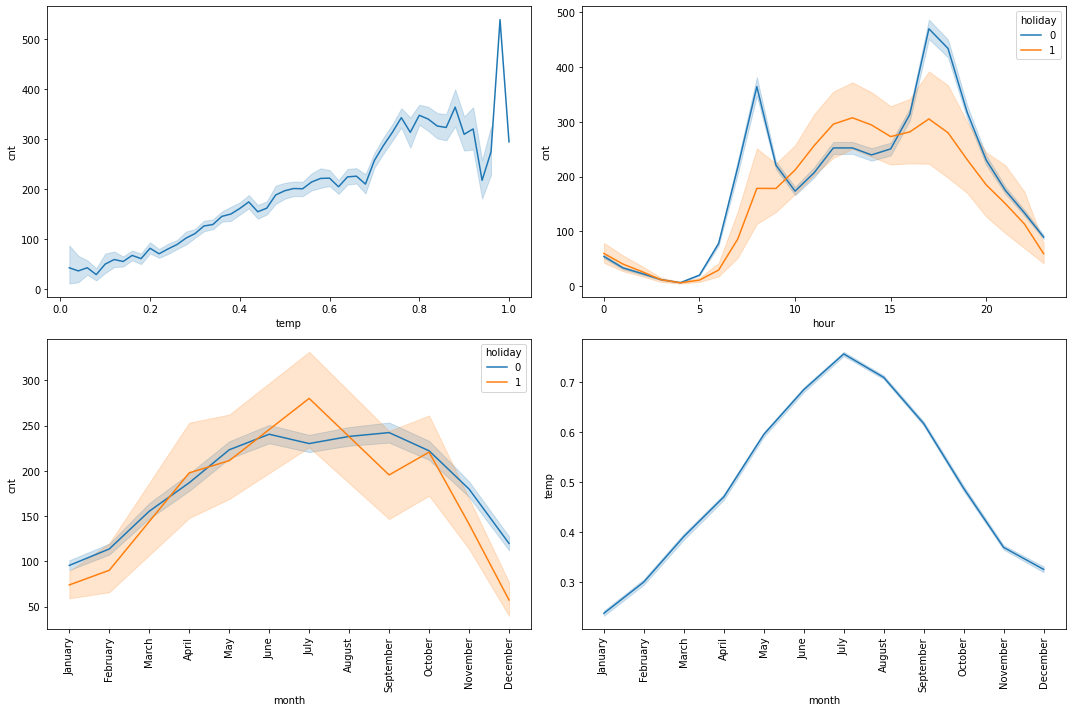

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10)) 

# Plot 1
plt.subplot(2, 2, 1) 
lineplot(data=train_plot, x='temp', y='cnt')

# Plot 2
plt.subplot(2, 2, 2) 
lineplot(data=train_plot, x='hour', y='cnt', hue='holiday')

# Plot 3
plt.subplot(2, 2, 3)
lineplot(data=train_plot, x='month', y='cnt', hue='holiday')
plt.xticks(rotation=90)

# Plot 4
plt.subplot(2, 2, 4)  
lineplot(data=train_plot, x='month', y='temp')
plt.xticks(rotation=90)

plt.tight_layout() 
plt.show()


**Grafiek 1**
In de eerste grafiek zien wij een stijgende correlatie tussen de temperatuur en het aantal verhuringen. Dit betekent dat als de temperatuur toeneemt, is er ook een stijging in de hoeveelheid verhuringen. 

**Grafiek 2**
In de tweede grafiek zien we nogmaals uren tegenover de hoeveelheid verhuringen. Toch zien wij in deze grafiek iets anders, wij zien hier ook bij of het een vakantie is of niet. Wat hier opvalt is dat de pieken tijdens de spits ontbreken tijdens de vakantieperiode. Dit is hoogswaarschijnlijk zo, omdat mensen dan niet onderwg naar hun werk hoeven en het daardoor niet nodig is om het product te huren. 

**Grafiek 3**
De derde grafiek is overeenkomstig met de tweede grafiek, maar in dit geval worden maanden in plaats van uren aangetoont. Het merkwaardige hieraan is dat er ook een correlatie met het temperatuur is te zien. Dit is te zien aan waar de pieken te vinden zijn, namelijk in de zomermaanden. 

**Grafiek 4**
In de vierde grafiek is de temperatuur over de maanden te zien. Hieruit kunnen wij zien dat in juli de temperatuur het hoogst is vergeleken met de andere maanden. Hierdoor kan je de bevindingen van grafiek drie onderbouwen. 

**Subconclusie**

We hebben gezien dat de temperatuur, de tijd van de dag en welke maand het is de  de meeste invloed hebben op hoeveel er wordt verhuurd. Dit hebben we gezien in de corrielatie plot. Want ons ook is opgevallen is dat de data al van te voren is genormaliseerd. Want we zien dat geen van de kolommen een grotere waarde hebben dan 1. Behalve de kolommen weathersit, holiday, want deze kolommen zijn namelijk binair. Die kan je niet normaliseeren. 

**Visualisaties reguliere features**

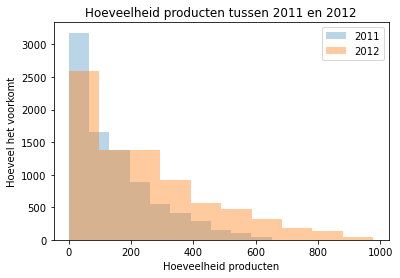

In [13]:
plt.hist(train_plot[train_plot['year'] == 2011]['cnt'], alpha=0.3, label='2011')
plt.hist(train_plot[train_plot['year'] == 2012]['cnt'], alpha=0.4, label='2012')

plt.xlabel("Hoeveelheid producten")
plt.ylabel("Hoeveel het voorkomt")
plt.title("Hoeveelheid producten tussen 2011 en 2012")
plt.legend()
plt.show()


In [14]:
print(len(train_model[train_model['year'] == 2011]))
print(len(train_model[train_model['year'] == 2012]))
print(len(train_model[train_model['year'] == 2011]) - len(train_model[train_model['year'] == 2012]))
653/24

8645
7992
653


27.208333333333332

In [15]:
len(test)/24

19.0

Hier kunnen we zien dat de weersomstandigheden goed correleren met de hoeveelheid van spullen er worden gehuurd.
Je kan hier zien dat er in 2012 een verhoging is van het aantal verhuringen. In beide jaren is het bij clear weer het meest verhuurd. 

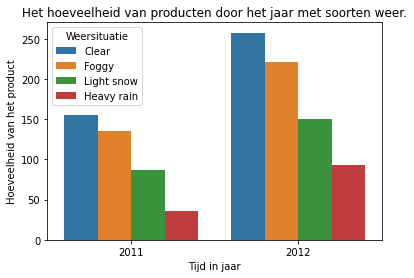

In [16]:
sns.barplot(data=train_plot, x='year', y='cnt', hue='weathersit', ci = None)
plt.xlabel("Tijd in jaar")
plt.ylabel("Hoeveelheid van het product")
plt.title("Het hoeveelheid van producten door het jaar met soorten weer.")
legend_labels = ['Clear', 'Foggy', 'Light snow', 'Heavy rain']
plt.legend(title='Weersituatie', labels=legend_labels)


In dit grafiek zien we dat de tempratuur en gevoels tempratuur sterk met elkaar correleren. Dit komt goed overheen met onze verwachtingen.

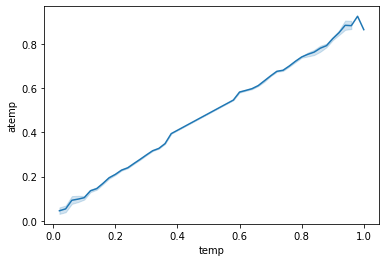

In [17]:
lineplot(data=train_plot, x='temp', y='atemp')


In deze grafiek zien we dat de tempratuur en gevoels tempratuur sterk met elkaar correleren. Dit hadden we al verwacht maar is mooi om zo te zien.

**Conclusie**

Aan de hand van de corrielatie plots en de tijdreeks grafieken kunnen we zien dat tempratuur, humidity, atemp en hour als kolommen al een grote rol spelen. Zo kunnen we zien dat rond de spits tijden door de weeks erg druk is en in het weekend deze stijging niet voorkomt. Hieruit kunnen we aan afleiden dat er hoogst waarschijnlijk wel een dag pratroon bestaat. Door de grafiek kunnen we ook al vertellen dat er een weekelijks patroon is. Want elke week krijg je weer redelijk hetzelfde patroon te zien. Ook zien we dat het weer een grote rol speelt. Zo zien we dat de als het warm is meer mensen willen huren en als de weer type clear is, is het populair om te gaan huren.


**Bronnen voor Visualisatie**

Matplotlib.pyplot.figure — matplotlib 3.8.2 documentation. (z.d.). https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html

Seaborn.barplot — Seaborn 0.13.0 documentation. (z.d.). https://seaborn.pydata.org/generated/seaborn.barplot.htmlhttps://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html

**Schoonmaken kolommen**

In [18]:
display(train_model.columns)
display(test_model.columns)

Index(['date_hour', 'holiday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'cnt', 'day_of_month', 'day_of_week', 'month', 'year',
       'hour', 'Week'],
      dtype='object')

Index(['date_hour', 'holiday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'day_of_month', 'day_of_week', 'month', 'year', 'hour',
       'Week'],
      dtype='object')

We kunnen zien dat er geen onnodige kolomen zijn. Dus hebben we besloten alles te behouden.

## Time series feature engineering

**Moving average plot**

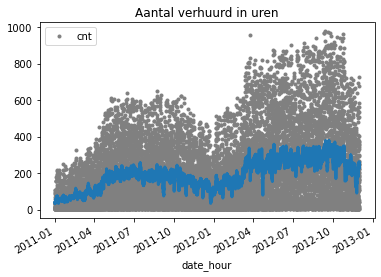

<AxesSubplot:xlabel='date_hour'>

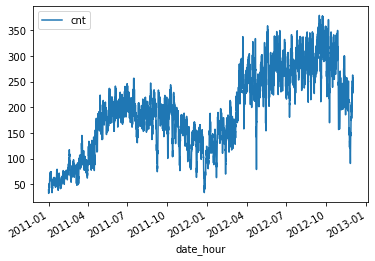

In [14]:
train_model["date_hour"] = pd.to_datetime(train_model["date_hour"])
roll_train = train_model[["date_hour", "cnt"]].set_index("date_hour")

moving_average = roll_train.rolling(window=52, center=True, min_periods=26).mean()             

ax = roll_train.plot(style=".", color="0.5")
moving_average.plot(ax=ax, linewidth=3, title="Aantal verhuurd in uren", legend=False,)

plt.show()
moving_average.plot()

#Bij een moving average bereken je het gemiddelde voor elk punt in de tijd, nadat je het gemiddelde hebt berekend schuif
#je het venster een stap op en bereken je daar ook het gemiddelde voor. Dit doe je voor elk volgend punt ook. 
#Uiteindelijk krijg je dus een nieuwe lijn (bij ons de blauwe lijn) wat dus laat zien wat de moving average is.

**Tijdreeks ontleden in trend, seizoensinvloeden en residuen**

In [15]:
#Hier zorgen wij ervoor dat roll_train een seizoenscomponent bevat met een uren frequentie.
date_range = pd.date_range(start=roll_train.index[0], end=roll_train.index[-1], freq='H')

seasonal_component = pd.DataFrame(index=date_range, columns=['seasonal'])
seasonal_component['seasonal'] = np.nan  
seasonal_component['seasonal'] = np.sin(2 * np.pi * seasonal_component.index.hour / 24)

roll_train_seasonal = roll_train.merge(seasonal_component, how='left', left_index=True, right_index=True)

In [16]:
#Deze functie splits de Time series op in een trend, seasonal en een residual.
import statsmodels.api as sm

def decompose_ts(series, period=None):


    decompose = sm.tsa.seasonal_decompose(series, period=period)
    
    trend = decompose.trend
    seasonal = decompose.seasonal
    resid = decompose.resid

    return trend, seasonal, resid

Lengte roll_train index: 16637
Lengte roll_train trend: 16637
NaNs in trend: 0


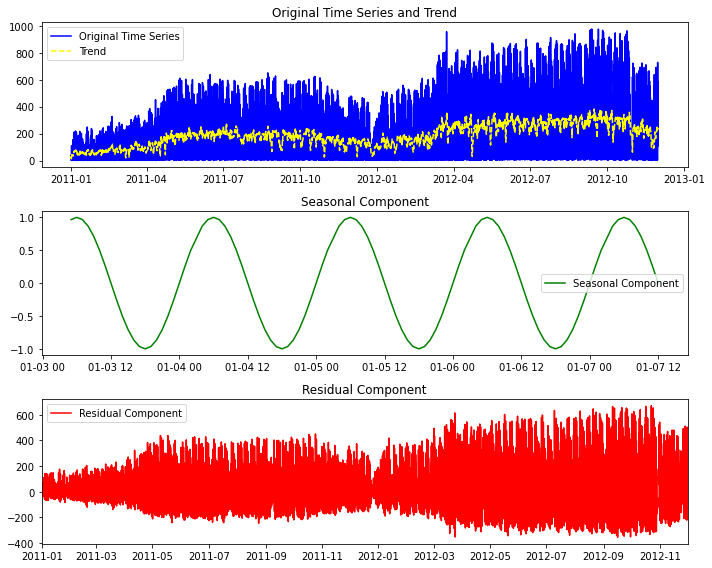

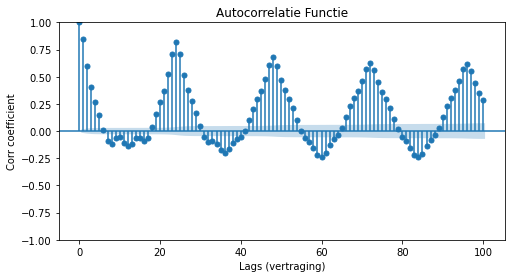

C:\Users\caspe\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


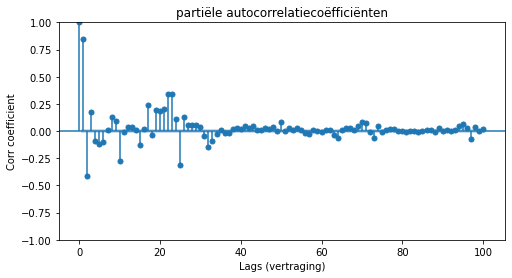

In [17]:
#Deze functie geeft een plot van de trend, seasonal en de residual.
import matplotlib.pyplot as plt

def calculate_trend(data, window_size):
    """
    Calculate the rolling mean trend of a given dataset.

    Parameters:
    - data (pd.Series): The time-series data for which the trend is to be calculated.
    - window_size (int): The size of the rolling window used to compute the mean.

    Returns:
    pd.Series: A new time-series representing the rolling mean trend.
    """
    trend = data.rolling(window=window_size, min_periods=1).mean()
    return trend


def plot_ts(df, trend, seasonal, residuals, x_range=None):
    """
    Plot the original time series along with its trend, seasonal component, and residuals.

    Parameters:
    - df (pd.DataFrame): The original time series data with a datetime index.
    - trend (pd.Series): The trend component of the time series.
    - seasonal (pd.Series): The seasonal component of the time series.
    - residuals (pd.Series): The residual component of the time series.
    - x_range (tuple, optional): A tuple specifying the range of x-axis values to plot for the seasonal component.

    Returns:
    None
    """
    
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

    #Dit laat zien dat het inderdaad op de uur data word uitgevoerd en dat de trend ook in uren word berekend
    print("Lengte roll_train index:", len(df.index))
    print("Lengte roll_train trend:", len(trend))
    print("NaNs in trend:", trend.isnull().sum())

    #Plot de trend(geel) en orginele tijdseries(blauw)
    axes[0].plot(df.index, df.iloc[:, 0], color='blue', label='Original Time Series')
    axes[0].plot(df.index, trend, color='yellow', linestyle='dashed', label='Trend')
    axes[0].set_title('Original Time Series and Trend')
    axes[0].legend()

    #Plot de seizoenscomponent
    if x_range is not None:
        axes[1].plot(df.index[x_range[0]:x_range[1]], seasonal[x_range[0]:x_range[1]], color='green', label='Seasonal Component')
    else:
        axes[1].plot(df.index, seasonal, color='green', label='Seasonal Component')
    axes[1].set_title('Seasonal Component')
    axes[1].legend()

    #Plot de residual
    axes[2].plot(df.index, residuals, color='red', label='Residual Component')
    axes[2].set_title('Residual Component')

    axes[2].set_xlim(df.index[0], df.index[-1])
    axes[2].legend()

    plt.tight_layout()
    plt.show()


roll_train_trend = calculate_trend(roll_train_seasonal['cnt'], window_size=24)
seasonal = roll_train_seasonal['seasonal']
residuals = roll_train_seasonal['cnt'] - roll_train_trend - seasonal


plot_ts(roll_train_seasonal, roll_train_trend, seasonal, residuals, x_range=[50, 150])

fig, ax = plt.subplots(figsize=(8, 4))

plot_acf(roll_train['cnt'], lags=100, ax=ax)
ax.set_title('Autocorrelatie Functie')
ax.set_xlabel('Lags (vertraging)')
ax.set_ylabel('Corr coefficient')

plt.show()

fig, ax = plt.subplots(figsize=(8, 4))

plot_pacf(roll_train['cnt'], lags=100, ax=ax)
ax.set_title('partiële autocorrelatiecoëfficiënten')
ax.set_xlabel('Lags (vertraging)')
ax.set_ylabel('Corr coefficient')

plt.show()


**Seizoenspatronen**

Wij hebben hier "roll_train_seasonal" gemaakt met de frequentie per uur. Wij hebben hier uur gebruikt, omdat er zoals in de visualisaties eerder kon worden gezien tijdens de spits een piek is in het aantal verhuuurde exemplaren. Hierboven in het plot bij de seasonalcomponent hadden wij eerst één groot groen vlak, hierdoor zijn wij gaan inzoomen om te bekijken of het door het aantal golven kwam en dat bleek zo te zijn. Nu zien wij dat er duidelijk om de 24 uur een golf voorbij is.

**Trends**

Wij hebben "roll_train_trend" gemaakt wat de gele lijn weergeeft, als de trend stijgt dan is er een algemene stijging van aantal verhuurde exemplaren over tijd, als de trend daalt is dit een afname over tijd. Dit geeft ons belangrijke gegevens waardoor we kunnen kijken wat er op lange termijn gebeurd. Wij kunnen dus zien dat per jaar bepaalde pieken zijn, dit ligt ongeveer tussen april en oktober, buiten deze maanden daalt de verhuur weer dit komt omdat het erg koud word. Ook zien wij over het algemeen een stijging van het aantal verhuurde exemplaren dus er word elk jaar gemiddeld meer verhuurd.

**Cycli en Autocorrelatie**

Cycli in tijdreeksen zijn steeds weer herhaalde patronen in een periode. In onze visualisatie zien we dat er meerdere cycli zijn. Zo zien wij namelijk dat er om de 24 uur hetzelfde patroon zich herhaalt dus in de nacht word er niks verhuurd en in de spits het meest, hier spreken wij dus over een dagpatroon. Als je verder kijkt kun je ook zien dat er per jaar een patroon is, zoals aangegeven hierboven zien we dat er in de warmere maanden er meer worden verhuurd dan in de koudere maanden en dit gebeurd elk jaar dus spreken we over een jaarlijkspatroon dit betekend dat er dus cyclische variaties zijn die elk jaar terugkomen.

Autocorrelatie laat zien hoe erg je waarde correleert met de waardes daarvoor. Dit kan duidelijkheid geven over afhankelijkheid van waardes in de tijdreeks (dit kun je zien in de 4e afbeelding). Wij hebben gekozen voor 100 lags zodat we duidelijk een overzicht zien van de correlatie van meerdere waardes. Zoals je ziet is de autocorrelatie plot hetzelfde als de seasonal component plot, dit komt omdat het gaat over dagelijkse verhuurcijfers, dit laat dus zien dat de pieken overeenkomen met dezelfde dagen.

Ook hebben wij nog een PACF uitgevoerd dit focust zich op partiele correlatie op individuele lags.


**Andere tijdsgebaseerde features**

Wij hebben ook nog gebruik gemaakt van andere tijdsgebaseerde features zoals hierboven hebben wij ook nog de moving average berekend, dit laat namelijk het gemiddelde zien over verschillende vensters. We voegen later ook nog Dummy kolommen toe aan het dataframe. Dit doen we omdat we door middel van de extra kolommen makkelijker kunnen voorspellen welke waarden cnt moet hebben.

**Bronnen**

De NoteBook van de les: Time_series_analysis_1_Trend_and_decomposition_Solutions,

Ryanholbrook. (2023, 20 april). Trend. Kaggle. https://www.kaggle.com/code/ryanholbrook/trend


**Fast Fourier Transform**

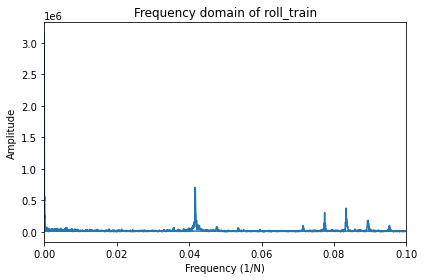

In [18]:
N = len(roll_train)

y_train_ft = np.fft.fftfreq(N, 1)
ant = np.fft.fft(roll_train['cnt'])

plt.plot(y_train_ft, np.abs(ant))
plt.xlabel('Frequency (1/N)')
plt.ylabel('Amplitude')
plt.title("Frequency domain of roll_train")
plt.xlim([0,0.10])

plt.tight_layout()
plt.show()

De Fast Fourier Transform (FFT) gebruiken wij omdat we graag het frequentiedomein willen bekijken, dit laat zoen hoe frequentiecomponenten zijn verdeed in ons signaal.


In [19]:
df = pd.DataFrame()
df['freq'] = y_train_ft
df['amplitude'] = np.abs(ant)
df['tijd_uren'] = 1/y_train_ft
df_filterd = df.copy()
df_filterd = df_filterd[df_filterd['amplitude'] >= 300000]
df_filterd = df_filterd[df_filterd['freq']> 0]
df_filterd.sort_values('amplitude', ascending=False)

C:\Users\caspe\AppData\Local\Temp\ipykernel_25108\4113576939.py:4: RuntimeWarning: divide by zero encountered in true_divide
  df['tijd_uren'] = 1/y_train_ft


,freq,amplitude,tijd_uren
692,0.041594,702799.953019,24.041908
694,0.041714,699280.808600,23.972622
2,0.000120,560236.241034,8318.500000
1,0.000060,489864.299841,16637.000000
695,0.041774,479527.144257,23.938129
1387,0.083368,375575.609672,11.994953
696,0.041834,307463.826990,23.903736
1288,0.077418,306064.251401,12.916925


Hier kunnen we de gevonden frequenties in het grafiek terug vinden in de dataframe. Zo kunnen we nu zien dat er een duidelijke dag, jaar en een halve dag patroon is. Het grootste partoon die er is, is het dag partoon.

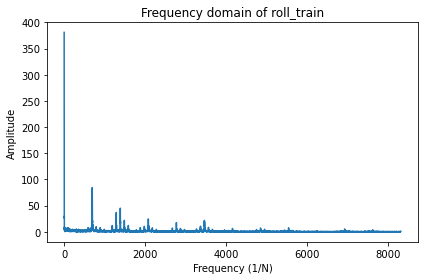

In [20]:
N = len(roll_train)

train_ft = np.fft.fft(roll_train['cnt'])

magnitude = 2.0/N * np.abs(train_ft[:N//2])

plt.plot(magnitude)
plt.xlabel('Frequency (1/N)')
plt.ylabel('Amplitude')
plt.title("Frequency domain of roll_train")

plt.tight_layout()
plt.show()

In deze fft zorgen wij ervoor dat het frequentiebereikword berekend door het aantal punten in de tijdreeks.
Ook zorgen we hier ervoor dat de magnitude goed word geschaald en we stellen geen x-as limiet in, dit zorgt ervoor dat er  normalisatie van de amplitudes en juiste weergave van de frequentie-as hebben weergegeven.








Peaks found at [   2  692  694 1387]


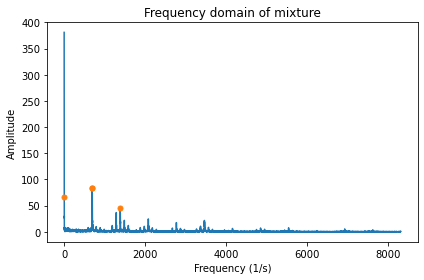

In [21]:
#Hier vinden wij de pieken in de fast fourier transform
from scipy.signal import find_peaks
peaks, _ = find_peaks(magnitude, height=45) 

print(f"Peaks found at {peaks}")

plt.plot(magnitude)
plt.xlabel('Frequency (1/s)')
plt.ylabel('Amplitude')
plt.title("Frequency domain of mixture")

plt.plot(peaks, magnitude[peaks], ".", markersize=10)

plt.tight_layout()
plt.show()

**Pieken**

het vinden van de pieken in de fft is belangrijk, omdat deze pieken correleren met de frequentiecomponent in ons normale signaal. Dit geeft dus meer kennis over de cyclische patronen en periodieke trends in onze gegevens.


In [22]:
#Frequentie van de pieken
print(2*(1/len(roll_train)))
print(692*(1/len(roll_train)))
print(694*(1/len(roll_train)))
print(1387*(1/len(roll_train)))

0.00012021398088597704
0.04159403738654806
0.041714251367434035
0.08336839574442508


Door het gebruik van de Find_peaks methoden kunnen we zien dat we precies de zelfde frequenties hebben als die we hebben gevonden in het dataframe.

**Bronnen voor de Fourier**

De note book van de les: Regression_Time_Series_3_oplossing

In [23]:
train_zonder = train_model.copy()

In [24]:
trend, seasonal, resid = decompose_ts(roll_train, period= 12)
train_model["date"] = pd.to_datetime(train_model['year'].astype(str) + '-' + train_model['month'].astype(str) + '-' + train_model["day_of_month"].astype(str))
train_model.set_index("date", inplace=True)
train_model["trend"] = trend
train_model["seasonal"] = seasonal
train_model["resid"] = resid
train_model

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,day_of_month,day_of_week,month,year,hour,Week,trend,seasonal,resid
date,,,,,,,,,,,,,,,,,
2011-01-01,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,1,5,1,2011,0,52,NaN,8.288947,NaN
2011-01-01,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,1,2011,1,52,NaN,8.288947,NaN
2011-01-01,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,1,5,1,2011,2,52,NaN,8.288947,NaN
2011-01-01,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,1,5,1,2011,3,52,NaN,8.288947,NaN
2011-01-01,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,1,5,1,2011,4,52,NaN,8.288947,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,30,4,11,2012,19,48,128.041667,-17.455066,-58.586601
2012-11-30,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,30,4,11,2012,20,48,128.041667,-17.455066,-58.586601
2012-11-30,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,30,4,11,2012,21,48,128.041667,-17.455066,-58.586601


In [25]:
tst = train_model.copy()
tst.reset_index()
tst.set_index('date_hour', inplace = True)
tst

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,day_of_month,day_of_week,month,year,hour,Week,trend,seasonal,resid
date_hour,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,1,5,1,2011,0,52,NaN,8.288947,NaN
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,1,2011,1,52,NaN,8.288947,NaN
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,1,5,1,2011,2,52,NaN,8.288947,NaN
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,1,5,1,2011,3,52,NaN,8.288947,NaN
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,1,5,1,2011,4,52,NaN,8.288947,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,30,4,11,2012,19,48,128.041667,-17.455066,-58.586601
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,30,4,11,2012,20,48,128.041667,-17.455066,-58.586601
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,30,4,11,2012,21,48,128.041667,-17.455066,-58.586601


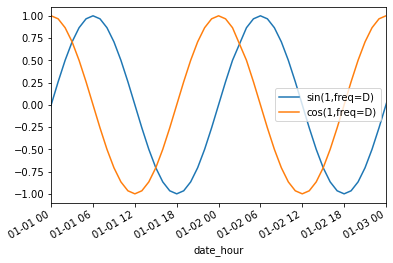

In [26]:
# Aanmaken fourier voor W en D
train['date_hour'] = pd.to_datetime(train['date_hour'])
train.set_index('date_hour', inplace=True)
fourier_w = CalendarFourier(freq="W", order=1)
fourier_d = CalendarFourier(freq="D", order=1)

dp = DeterministicProcess(
    index=train.index,
    constant=False,
    order=1,
    seasonal=False,
    additional_terms=[fourier_w, fourier_d],
    drop=True,
)

fourier_feat = dp.in_sample()

ax = fourier_feat.plot(y='sin(1,freq=D)',
                       xlim=['2012-01-01', '2012-01-03'])
ax = fourier_feat.plot(ax=ax, y='cos(1,freq=D)',
                       xlim=['2012-01-01', '2012-01-03'])
plt.show()



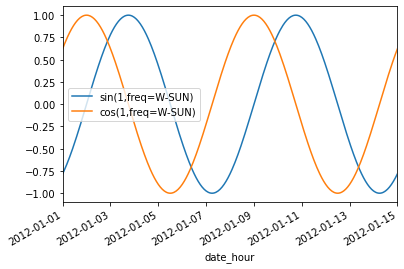

In [27]:
ax = fourier_feat.plot(y='sin(1,freq=W-SUN)',
                       xlim=('2012-01-01', '2012-01-15'))
ax = fourier_feat.plot(ax=ax, y='cos(1,freq=W-SUN)',
                       xlim=('2012-01-01', '2012-01-15'))
plt.show()

In deze grafieken kunnen we duidelijk de patronen zien in verloop met de tijd. Zo kunnen we een week patroon en een week partoon zien door midden van de sinus en cosinus.

In [28]:
fourier_merged = pd.merge(tst, fourier_feat, left_index=True, right_index=True)
fourier_merged.drop('trend_x', axis = 1, inplace = True)
fourier_merged.reset_index(inplace = True)
fourier_merged

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,day_of_month,day_of_week,...,year,hour,Week,seasonal,resid,trend_y,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(1,freq=D)","cos(1,freq=D)"
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,1,5,...,2011,0,52,8.288947,NaN,1.0,-0.974928,-0.222521,0.000000,1.000000
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,...,2011,1,52,8.288947,NaN,2.0,-0.982566,-0.185912,0.258819,0.965926
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,1,5,...,2011,2,52,8.288947,NaN,3.0,-0.988831,-0.149042,0.500000,0.866025
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,1,5,...,2011,3,52,8.288947,NaN,4.0,-0.993712,-0.111964,0.707107,0.707107
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,1,5,...,2011,4,52,8.288947,NaN,5.0,-0.997204,-0.074730,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,30,4,...,2012,19,48,-17.455066,-58.586601,16633.0,-0.916562,-0.399892,-0.965926,0.258819
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,30,4,...,2012,20,48,-17.455066,-58.586601,16634.0,-0.930874,-0.365341,-0.866025,0.500000
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,30,4,...,2012,21,48,-17.455066,-58.586601,16635.0,-0.943883,-0.330279,-0.707107,0.707107
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,30,4,...,2012,22,48,-17.455066,-58.586601,16636.0,-0.955573,-0.294755,-0.500000,0.866025


**Bronnen voor de DeterministicProcess**

De note book van de les: Regression_Time_Series_3_oplossing

In [29]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(0, lags + 1)
        },
        axis=1)

df_lags = make_lags(roll_train['cnt'], lags=7)
df_lags = df_lags.fillna(0.0)
df_lags.reset_index()

,date_hour,y_lag_0,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7
0,2011-01-01 00:00:00,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 01:00:00,40,16.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 02:00:00,32,40.0,16.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 03:00:00,13,32.0,40.0,16.0,0.0,0.0,0.0,0.0
4,2011-01-01 04:00:00,1,13.0,32.0,40.0,16.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,377,509.0,582.0,405.0,296.0,251.0,262.0,268.0
16633,2012-11-30 20:00:00,245,377.0,509.0,582.0,405.0,296.0,251.0,262.0
16634,2012-11-30 21:00:00,183,245.0,377.0,509.0,582.0,405.0,296.0,251.0
16635,2012-11-30 22:00:00,163,183.0,245.0,377.0,509.0,582.0,405.0,296.0


**Bronnen voor de Lags**

De note book van de les: Regression_Time_Series_3_oplossing

Ryanholbrook. (2023a, april 20). Time series as features. Kaggle. https://www.kaggle.com/code/ryanholbrook/time-series-as-features


# Modelleren

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def train_regression_model(df, model_type, model_params):

    """
    Train a regression model using the provided data and hyperparameters, and evaluate its performance.

    Parameters:
    - df (pd.DataFrame): The input data with features and target variable.
    - model_type (estimator): The regression model estimator (e.g., LinearRegression(), RandomForestRegressor()).
    - model_params (dict): Hyperparameters to be tuned using GridSearchCV.

    Returns:
    est: The best-trained regression model.
    """
    
    X = df.drop(['date_hour', 'cnt'], axis=1)
    y = df['cnt']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    grid_search = GridSearchCV(model_type, model_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    MSE = mean_squared_error(y_test, y_pred)
    RMSE = MSE**0.5
    R2 = r2_score(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)

    print("Best Parameters:", best_params)
    print("Mean Squared Error (MSE):", MSE)
    print("Root Mean Squared Error (RMSE):", RMSE)
    print("R-squared (R2):", R2)
    print("Mean Absolute Error (MAE):", MAE)

    return best_model

**Prediction zonder timeserie features**

In [31]:
train_zonder_feature = train_zonder.copy()
train_zonder_feature

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,day_of_month,day_of_week,month,year,hour,Week
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,1,5,1,2011,0,52
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,1,2011,1,52
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,1,5,1,2011,2,52
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,1,5,1,2011,3,52
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,1,5,1,2011,4,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,30,4,11,2012,19,48
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,30,4,11,2012,20,48
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,30,4,11,2012,21,48
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,30,4,11,2012,22,48


In [32]:
model_parameters = {'n_estimators': [100], 'max_depth': [10], 'random_state': [42]}
trained_model = train_regression_model(train_zonder_feature, model_type=RandomForestRegressor(), model_params=model_parameters)

Best Parameters: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Mean Squared Error (MSE): 7707.222313670791
Root Mean Squared Error (RMSE): 87.79078717992446
R-squared (R2): 0.8502526882628385
Mean Absolute Error (MAE): 57.53697192903135


**Prediction met timeserie features**

In [33]:
train_ts_feature = fourier_merged.drop(['seasonal', 'resid'], axis = 1)
train_ts_feature

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,day_of_month,day_of_week,month,year,hour,Week,trend_y,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(1,freq=D)","cos(1,freq=D)"
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,1,5,1,2011,0,52,1.0,-0.974928,-0.222521,0.000000,1.000000
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,1,5,1,2011,1,52,2.0,-0.982566,-0.185912,0.258819,0.965926
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,1,5,1,2011,2,52,3.0,-0.988831,-0.149042,0.500000,0.866025
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,1,5,1,2011,3,52,4.0,-0.993712,-0.111964,0.707107,0.707107
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,1,5,1,2011,4,52,5.0,-0.997204,-0.074730,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,30,4,11,2012,19,48,16633.0,-0.916562,-0.399892,-0.965926,0.258819
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,30,4,11,2012,20,48,16634.0,-0.930874,-0.365341,-0.866025,0.500000
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,30,4,11,2012,21,48,16635.0,-0.943883,-0.330279,-0.707107,0.707107
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,30,4,11,2012,22,48,16636.0,-0.955573,-0.294755,-0.500000,0.866025


Hier zien we de scoren als we de hele kolommen droppen waar we wat missende waardes in hebben.

In [34]:
model_parameters = {'n_estimators': [100], 'max_depth': [10], 'random_state': [42]}
trained_model = train_regression_model(train_ts_feature, model_type=RandomForestRegressor(), model_params=model_parameters)

Best Parameters: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Mean Squared Error (MSE): 7057.841364300886
Root Mean Squared Error (RMSE): 84.01095978680928
R-squared (R2): 0.8628698215832284
Mean Absolute Error (MAE): 53.44647992501872


In [35]:
train_ts_featuret = fourier_merged.dropna()
train_ts_featuret

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,day_of_month,day_of_week,...,year,hour,Week,seasonal,resid,trend_y,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(1,freq=D)","cos(1,freq=D)"
24,2011-01-02 00:00:00,0,2,0.46,0.4545,0.88,0.2985,17,2,6,...,2011,0,52,8.288947,-11.788947,25.0,-0.781831,0.623490,0.000000,1.000000
25,2011-01-02 01:00:00,0,2,0.44,0.4394,0.94,0.2537,17,2,6,...,2011,1,52,8.288947,-11.788947,26.0,-0.757972,0.652287,0.258819,0.965926
26,2011-01-02 02:00:00,0,2,0.42,0.4242,1.00,0.2836,9,2,6,...,2011,2,52,8.288947,-11.788947,27.0,-0.733052,0.680173,0.500000,0.866025
27,2011-01-02 03:00:00,0,2,0.46,0.4545,0.94,0.1940,6,2,6,...,2011,3,52,8.288947,-11.788947,28.0,-0.707107,0.707107,0.707107,0.707107
28,2011-01-02 04:00:00,0,2,0.46,0.4545,0.94,0.1940,3,2,6,...,2011,4,52,8.288947,-11.788947,29.0,-0.680173,0.733052,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,30,4,...,2012,19,48,-17.455066,-58.586601,16633.0,-0.916562,-0.399892,-0.965926,0.258819
16633,2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,30,4,...,2012,20,48,-17.455066,-58.586601,16634.0,-0.930874,-0.365341,-0.866025,0.500000
16634,2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,30,4,...,2012,21,48,-17.455066,-58.586601,16635.0,-0.943883,-0.330279,-0.707107,0.707107
16635,2012-11-30 22:00:00,0,1,0.30,0.3333,0.75,0.0000,163,30,4,...,2012,22,48,-17.455066,-58.586601,16636.0,-0.955573,-0.294755,-0.500000,0.866025


Hier zien we de code van als de alleen de rijen met missende waardes droppen. We kunnen duidelijk zien dat we nu beter scoren dat als we de hele kolommen verwijderen. Het zijn ook maar 90 rijen van de 16637 in totaal. Maar omdat te maken hebben met timeseries dachten we dat het misschien iets slechter zou voorspellen omdat we nu wat missen in de timeline. Maar dat lijkt niet het geval te zijn.

In [36]:
model_parameters = {'n_estimators': [100], 'max_depth': [10], 'random_state': [42]}
trained_model = train_regression_model(train_ts_featuret, model_type=RandomForestRegressor(), model_params=model_parameters)

Best Parameters: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Mean Squared Error (MSE): 6272.253822468493
Root Mean Squared Error (RMSE): 79.19756197300832
R-squared (R2): 0.8784090668110879
Mean Absolute Error (MAE): 51.08156872258969


**Deel 2**

In [37]:
train_ts_feature2 = pd.get_dummies(data = train_ts_feature, columns=['weathersit','holiday','day_of_week', 'hour'])
train_ts_feature2

,date_hour,temp,atemp,hum,windspeed,cnt,day_of_month,month,year,Week,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2011-01-01 00:00:00,0.24,0.2879,0.81,0.0000,16,1,1,2011,52,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-01 01:00:00,0.22,0.2727,0.80,0.0000,40,1,1,2011,52,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-01 02:00:00,0.22,0.2727,0.80,0.0000,32,1,1,2011,52,...,0,0,0,0,0,0,0,0,0,0
3,2011-01-01 03:00:00,0.24,0.2879,0.75,0.0000,13,1,1,2011,52,...,0,0,0,0,0,0,0,0,0,0
4,2011-01-01 04:00:00,0.24,0.2879,0.75,0.0000,1,1,1,2011,52,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0.32,0.3485,0.66,0.0000,377,30,11,2012,48,...,0,0,0,0,0,1,0,0,0,0
16633,2012-11-30 20:00:00,0.32,0.3485,0.66,0.0000,245,30,11,2012,48,...,0,0,0,0,0,0,1,0,0,0
16634,2012-11-30 21:00:00,0.30,0.3182,0.75,0.0896,183,30,11,2012,48,...,0,0,0,0,0,0,0,1,0,0
16635,2012-11-30 22:00:00,0.30,0.3333,0.75,0.0000,163,30,11,2012,48,...,0,0,0,0,0,0,0,0,1,0


In [38]:
model_parameters = {'n_estimators': [100], 'max_depth': [10], 'random_state': [42]}
trained_model = train_regression_model(train_ts_feature2, model_type=RandomForestRegressor(), model_params=model_parameters)

Best Parameters: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Mean Squared Error (MSE): 6091.933236829354
Root Mean Squared Error (RMSE): 78.05083751523333
R-squared (R2): 0.8816369129667709
Mean Absolute Error (MAE): 50.89208265648283


**Deel 3**

In [39]:
train_ts_feature3 = train_ts_feature2.merge(df_lags, on = 'date_hour')
train_ts_feature3

,date_hour,temp,atemp,hum,windspeed,cnt,day_of_month,month,year,Week,...,hour_22,hour_23,y_lag_0,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7
0,2011-01-01 00:00:00,0.24,0.2879,0.81,0.0000,16,1,1,2011,52,...,0,0,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 01:00:00,0.22,0.2727,0.80,0.0000,40,1,1,2011,52,...,0,0,40,16.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 02:00:00,0.22,0.2727,0.80,0.0000,32,1,1,2011,52,...,0,0,32,40.0,16.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 03:00:00,0.24,0.2879,0.75,0.0000,13,1,1,2011,52,...,0,0,13,32.0,40.0,16.0,0.0,0.0,0.0,0.0
4,2011-01-01 04:00:00,0.24,0.2879,0.75,0.0000,1,1,1,2011,52,...,0,0,1,13.0,32.0,40.0,16.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16632,2012-11-30 19:00:00,0.32,0.3485,0.66,0.0000,377,30,11,2012,48,...,0,0,377,509.0,582.0,405.0,296.0,251.0,262.0,268.0
16633,2012-11-30 20:00:00,0.32,0.3485,0.66,0.0000,245,30,11,2012,48,...,0,0,245,377.0,509.0,582.0,405.0,296.0,251.0,262.0
16634,2012-11-30 21:00:00,0.30,0.3182,0.75,0.0896,183,30,11,2012,48,...,0,0,183,245.0,377.0,509.0,582.0,405.0,296.0,251.0
16635,2012-11-30 22:00:00,0.30,0.3333,0.75,0.0000,163,30,11,2012,48,...,1,0,163,183.0,245.0,377.0,509.0,582.0,405.0,296.0


In [40]:
model_parameters = {'n_estimators': [100], 'max_depth': [10], 'random_state': [42]}
trained_model = train_regression_model(train_ts_feature3, model_type=RandomForestRegressor(), model_params=model_parameters)

Best Parameters: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Mean Squared Error (MSE): 18.79223996605964
Root Mean Squared Error (RMSE): 4.335001726188773
R-squared (R2): 0.9996348765739577
Mean Absolute Error (MAE): 0.45339909831882935


We hebben opgemerkt dat het toevoegen van de lag-functie aan het dataframe resulteert in aanzienlijk lagere scores. Echter, deze benadering brengt aanzienlijke nadelen met zich mee. Aangezien we 19 dagen willen voorspellen, impliceert dit dat het model steeds voorspelde waarden moet gebruiken voor het voorspellen van nieuwe waarden. Dit kan leiden tot een ophoping van fouten naarmate we verder in de toekomst kijken. Desondanks hebben we besloten om deze functie niet te gebruiken voor ons uiteindelijke model. Het gebruik ervan zou namelijk een aanzienlijk risico op overfitting met zich meebrengen, wat hoogstwaarschijnlijk de reden is achter onze opvallend goede score.

# Modeleren

### LinearReg

In [47]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

param_grid_linear_reg = {'fit_intercept': [True, False]}
trained_model = train_regression_model(train_ts_feature2, model_type=LinearRegression(), model_params=param_grid_linear_reg)

Best Parameters: {'fit_intercept': True}
Mean Squared Error (MSE): 20268.22192054777
Root Mean Squared Error (RMSE): 142.36650561332104
R-squared (R2): 0.6061990140195299
Mean Absolute Error (MAE): 105.68427782485392


In [48]:
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'fit_intercept': [True, False]}

trained_model = train_regression_model(train_ts_feature2, model_type=Ridge(), model_params=param_grid_ridge)


Best Parameters: {'alpha': 10.0, 'fit_intercept': False}
Mean Squared Error (MSE): 20129.422381517725
Root Mean Squared Error (RMSE): 141.87819558169508
R-squared (R2): 0.6088958167059193
Mean Absolute Error (MAE): 106.84034148966148


In [49]:
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'fit_intercept': [True, False]}
trained_model = train_regression_model(train_ts_feature2, model_type=Lasso(alpha = 0.01), model_params=param_grid_ridge)

Best Parameters: {'alpha': 0.01, 'fit_intercept': False}
Mean Squared Error (MSE): 20028.767143854748
Root Mean Squared Error (RMSE): 141.52302690323842
R-squared (R2): 0.6108514955015809
Mean Absolute Error (MAE): 106.45960159777107


C:\Users\caspe\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.693e+07, tolerance: 7.360e+04
  model = cd_fast.enet_coordinate_descent(


**Lineaire Regressie**

Lineaire regressie is een model dat de relatie tussen een afhankelijke variabele, vaak aangeduid met *“y”*, en één of meer onafhankelijke variabelen, aangeduid met *“x”*, modelleert. In een eenvoudige vorm met maar één onafhankelijke variabele is de formule:

*y = b0 + b1 * x + E*

waarbij:

- *b0* de intercept is,
- *b1* de helling (coëfficiënt) is,
- *x* is de onafhankelijke variabele,
- *E* is de foutterm.

Het doel van lineaire regressie is om de waarden van *b0* en *b1* te vinden die de fout (loss) *E* minimaliseert, waardoor het model de best passende lijn wordt voor de gegeven data.

**Loss Functie**

De loss functie bekijkt hoe goed het model presteert. Voor lineaire regressie wordt de Mean Squared Error (MSE) loss functie vaak gebruikt. De MSE is gedefinieerd als:

*MSE = (1/2m) * Σ (yi - (b0 + b1 * xi))^2*

waarbij:

- *m* het aantal datapunten is,
- *yi* de werkelijke waarde van de afhankelijke variabele voor datapunt i is,
- *xi* de waarde van de onafhankelijke variabele voor datapunt i is,
- *b0* en *b1* zijn de parameters die worden aangepast.

Het doel is om *b0* en *b1* te vinden die de MSE minimaliseren, wat betekent dat het gemiddelde van de gekwadrateerde fouten zo klein mogelijk moet zijn.

**Regularisatie**

Regularisatie wordt toegevoegd om overfitting te voorkomen door de grootte van de coëfficiënten te beperken. L2-regularisatie voegt een term toe aan de loss functie die proportioneel is met de som van de kwadraten van de coëfficiënten:

*Loss_L2 = MSE + λ * Σ b_j^2*

waarbij:

- *n* het aantal coëfficiënten is,
- *λ* de regularisatieparameter is die de sterkte van de regularisatie controleert.

L2-regularisatie dwingt de coëfficiënten naar nul toe, maar niet exact nul. Het voorkomt grote waarden van coëfficiënten, waardoor het model robuuster wordt voor variaties in de gegevens.

In conclusie combineert lineaire regressie met regularisatie het minimaliseren van de "loss" met het beheersen van de complexiteit van het model, wat zorgt voor een betrouwbare voorspelling.

**Bron bij LinReg**

Simple linear regression in R - articles - STHDA. (2018, 3 oktober). http://www.sthda.com/english/articles/40-regression-analysis/167-simple-linear-regression-in-r/#formula-and-basics

### Random Forest (Ensemble)

In [44]:
from sklearn.ensemble import RandomForestRegressor

param_grid_random_forest = {
    'n_estimators': [50, 100, 150], 
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False], 
    'random_state': [42]  }
trained_model = train_regression_model(train_ts_feature2, model_type=RandomForestRegressor(n_jobs = -1), model_params=param_grid_random_forest)



Best Parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 42}
Mean Squared Error (MSE): 7466.546593197033
Root Mean Squared Error (RMSE): 86.40918118578044
R-squared (R2): 0.8549288920460643
Mean Absolute Error (MAE): 57.70481384400634



**Random Forest**

Een Random Forest maakt gebruik van een reeks beslissingsregels om gegevens op te delen en uiteindelijk tot een voorspelling te komen. Laten we een boom noteren als *"T"* en de beslissingen op een knoop *"j"* als *"d_j"* naamgeven. Voor elke bladknoop *"l"* bevat *"T_l"* de voorspelling voor dat deel.

**Ensemble Methode**

Een Random Forest bestaat uit *"N"* beslissingsbomen, genoteerd als *"T_1, T_2, ..., T_N"*.

**Bootstrapped Datasets**

Bij het trainen van elke boom wordt een subset van de gegevens gemaakt door bootstrapping. Voor een dataset *"D"* van grootte *"m"*, wordt een bootstrapped dataset *"D_i"* voor boom *"i"* gemaakt.

**Willekeurige Selectie van Kenmerken**

Bij elke knoop van een beslissingsboom wordt een willekeurige subset van de kenmerken overwogen. Laten we *"F"* de totale set van kenmerken noemen en *"F_j"* de subset van kenmerken op knoop *"j"*.

**Voorspellingen Aggregeren**

Voor classificatie wordt de voorspelling *"h(x)"* van het ensemble genomen als de modus van de individuele voorspellingen *"h_i(x)"*.
Voor regressie wordt het gemiddelde genomen: 

*h(x) = (1/N) * Σ h_i(x)*

**Overfitting Voorkomen**

Door het gebruik van verschillende bomen met verschillende datapunten en kenmerken, helpt een Random Forest overfitting te verminderen. Het model is robuuster en generaliseert beter naar nieuwe gegevens.

**Out-of-Bag Error**

Het niet-gebruikte deel van de gegevens kan worden gebruikt als een "out-of-bag" (OOB) dataset om de prestaties van het model te evalueren. De OOB-fout wordt berekend op de datapunten die niet zijn opgenomen in de bootstrapsteekproef voor elke boom. De OOB-fout wordt berekend als: 

*OOB Error = (1/N) * Σ (1/|D \ D_i|) * Σ I{h_i(x) ≠ y}.*

**Bronnen bij RF**

Chakure, A. (2022, 7 maart). Random forest regression in Python explained. Built In. https://builtin.com/data-science/random-forest-python

OOB errors for random forests. (z.d.). scikit-learn. https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#:~:text=The%20out-of-bag%20(,whilst%20being%20trained%20%5B1%5D

### Decision Tree

In [45]:
from sklearn.tree import DecisionTreeRegressor

param_grid_decision_tree = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [42]}
trained_model = train_regression_model(train_ts_feature2, model_type=DecisionTreeRegressor(), model_params=param_grid_decision_tree)

Best Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'random_state': 42}
Mean Squared Error (MSE): 7906.301713926617
Root Mean Squared Error (RMSE): 88.91738701697558
R-squared (R2): 0.8463846792970562
Mean Absolute Error (MAE): 56.70478384462759


**Decision Tree**

Een Decision Tree is een model dat beslissingen neemt op basis van kenmerken van de gegevens om uiteindelijk tot een voorspelling te komen. In een beslissingsboom noteren we de beslissingen op een knoop *"j"* als *"d_j"*. Voor elke bladknoop *"l"* bevat de beslissingsboom de voorspelling voor die verdeling.

**Training van de Beslissingsboom**

Opdelen van de gegevens:
De boom begint met het selecteren van de beste splitsing voor de gegevens op basis van kenmerken.

Beslissingen bij Knopen:
Bij elke knoop van de boom wordt een beslissing genomen op basis van een bepaald kenmerk. De beslissingen worden genoteerd als *"d_j"*.

Bladknooppunten en Voorspellingen:
De boom eindigt in bladknooppunten waar voorspellingen worden gemaakt voor de datapunten in die verdeling.

**Overfitting Voorkomen**

Een beslissingsboom kan de neiging hebben om te veel te passen aan de trainingsgegevens, wat kan leiden tot overfitting. Om dit te voorkomen, kunnen strategieën zoals beperking van de boomdiepte (max_depth) worden toegepast.

**Impurity en Splitsingscriteria**

Tijdens het trainen van de beslissingsboom wordt de beste splitsing bepaald op basis van een bepaald criterium, zoals Gini-impurity of entropie.

**Gini-impurity**

*Gini Impurity(D)=1−∑ i=1(pi^2)*
waar pi de fractie van datapunten van klasse i in de partitie D is

**Entropie**

*Entropie(D)=−∑i=1(pi log^2(pi))*
waar pi dezelfde manier wordt gedefinieerd


Het doel is om de impurity te minimaliseren bij het maken van een splitsing.

**Bronnen bij DT**

Thorn, J. (2021, 13 december). Decision Trees explained - towards data science. Medium. https://towardsdatascience.com/decision-trees-explained-3ec41632ceb6

Singh, H. (2023, 6 november). GSplitting decision trees with gini impurity. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/03/how-to-select-best-split-in-decision-trees-gini-impurity/#:~:text=Entropy%20measures%20a%20set's%20disorder,but%20Gini%20favors%20larger%20partitions

### Gradient Boosting

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid_gradient_boosting = {
    'n_estimators': [50, 100, 150],  
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [42]}
trained_model = train_regression_model(train_ts_feature2, model_type=GradientBoostingRegressor(), model_params=param_grid_gradient_boosting)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150, 'random_state': 42}
Mean Squared Error (MSE): 8161.042168817504
Root Mean Squared Error (RMSE): 90.33848664228056
R-squared (R2): 0.8414352050561291
Mean Absolute Error (MAE): 71.87333356833454


**Gradient Boosting**

Gradient Boosting is een krachtige machine learning-techniek die zwakke voorspellingsmodellen combineert om een sterk model te bouwen. Het principe is om iteratief nieuwe modellen toe te voegen en deze modellen te trainen om de fouten van de vorige modellen te corrigeren.

**Stappen:**

1. initialisatie
Het proces begint met een initiële voorspelling *F0(x)*, vaak gekozen als het gemiddelde van de doelvariabele.

2. residuen berekenen
Voor elke datapunt *i*  berekenen we de residuen *ri *, die de fouten zijn tussen de werkelijke waarden *yi* en de huidige voorspelling *Fm(xi)*:

*ri = yi−Fm(xi)*

3. nieuw model bouwen
Een nieuw model *ℎm(x)* wordt getraind om de residuen *ri* te voorspellen.

4. learning rate
Een learning rate *η* wordt gebruikt om de bijdrage van elk nieuw model te reguleren. De nieuwe voorspelling wordt geüpdatet als:

*Fm+1(x)=Fm(x)+η⋅hm(x)*

5. herhaal
Herhaal de stappen 2-4 voor een vooraf bepaald aantal *M* modellen.

**Formules:**
De voorspelling van het ensemble wordt gegeven door de som van de voorspellingen van alle modellen, gewogen met de learning rate *η*:

*FM(x)=F0(x)+η⋅h1(x)+η⋅h2(x)+…+η⋅hM(x)*

De optimalisatie van het model omvat het minimaliseren van een bepaalde loss-functie, bijvoorbeeld de kwadratische fout voor regressie:

*L(y,FM(x))=∑i=1 N(yi−FM(xi))2*

De gradiënt van deze loss-functie ten opzichte van de voorspelling wordt gebruikt om de residuen te bepalen en het nieuwe model te trainen:

*ri=−(∂L(y,FM(x))/∂FM(xi))*

**Voordelen**

Robuustheid: Gradient Boosting is robuust en presteert goed op verschillende soorten gegevens.

Flexibiliteit: Het kan worden toegepast op zowel regressie- als classificatieproblemen.

Gradient Boosting kan verschillende vormen aannemen, zoals Gradient Boosting Machines (GBM), XGBoost, LightGBM, en CatBoost, die variaties zijn met verschillende optimalisaties en toevoegingen aan het basis algoritme.


**Bronnen bij GB**

Masui, T. (2022, 12 februari). All you need to know about gradient boosting Algorithm − Part 1. Regression. Medium. https://towardsdatascience.com/all-you-need-to-know-about-gradient-boosting-algorithm-part-1-regression-2520a34a502

### SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

param_grid_svr = {
    'C': [0.1, 5],          
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']}
trained_model = train_regression_model(train_ts_feature2, model_type=SVR(), model_params=param_grid_svr)

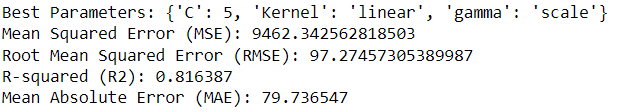

In [ ]:
#Voor het inleveren van het notebook moeten we wel hebben dat alle cells zijn gerund.
#Maar SVR doet er zo lang over dat hij waarschijnlijk niet klaar is voor 12 uur.
#Maar gelukkig is hij wel in een eerdere notebook gerund. Daarom staan de scoren als een plaatje.

**SVR**

Support Vector Regression (SVR) is een vorm van machine learning die wordt gebruikt voor regressieproblemen. Het maakt gebruik van support vector machines (SVM) om de fout tussen de voorspelde waarden en de werkelijke waarden te minimaliseren.

**Basisprincipes**

SVR is gebaseerd op de principes van SVM, waarbij het doel is om een hyperplane te vinden dat de fout tussen de voorspelde waarden en de werkelijke waarden minimaliseert, terwijl rekening wordt gehouden met fouten (epsilon E).

**Formules**

1. Lineaire SVR
In het geval van lineaire SVR is de voorspelling ŷ voor een gegeven input x gegeven door:
*ŷ(x)=w⋅x+b*
Waarbij: 
- *w* de gewichtsvector is en
- *b* de bias-term
De optimalisatie wordt uitgevoerd met de doelstelling om zowel de fouten als de complexiteit van het model te minimaliseren:

*min⁡ w,b ½ ∣∣w∣∣ ^2 + C ∑i=1 N (max⁡(0,∣yi−(w⋅x+b)∣−ϵ)) ^2*

Hierbij is *C* de kostenparameter die de trade-off tussen foutenminimalisatie en modelcomplexiteit regelt, en *ϵ* bepaalt de tolerantie voor fouten.

2. Niet-lineaire SVR:

In het geval van niet-lineaire SVR wordt de kerneltruc toegepast, waarbij de invoerdata worden afgebeeld naar een hoger dimensionale ruimte waarin een hyperplane kan worden gevonden. De voorspelling *ŷ* wordt dan gegeven door:

*ŷ(x)=∑i=1 N  αi k(xi,x)+b*

waarbij:
- *αi* de Lagrange-multipliers zijn die worden geoptimaliseerd
- *k(xi ,x)* is de kernelfunctie die de overeenkomst tussen *xi* en *x* meet
- *b* is de bias-term

**Voordelen**

Robuustheid: SVR is robuust tegenover overfitting, vooral in situaties waarbij de data ruis bevat.
Flexibiliteit: Door het gebruik van verschillende kernelfuncties kan SVR worden aangepast aan verschillende soorten data.


De exacte formulering van SVR kan variëren afhankelijk van de implementatie en de keuze van de kernelfunctie. De bovenstaande formules bieden echter een algemeen begrip van de wiskundige concepten achter SVR.


**Bronnen bij SVR**

Sethi, A. (2023, 14 september). Support Vector Regression tutorial for machine learning. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/03/support-vector-regression-tutorial-for-machine-learning/#:~:text=Support%20Vector%20Regression%20(SVR)%20is,while%20minimizing%20the%20prediction%20error.

### (S)ARIMA(X) models


Text(0.5, 1.0, 'PACF')

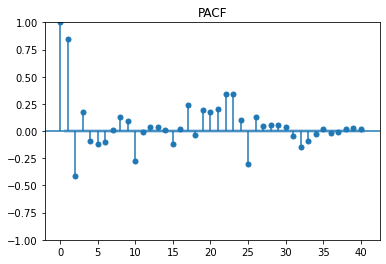

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

plot_pacf(train_model["cnt"], lags = 40, method = "ywm")
plt.title("PACF")


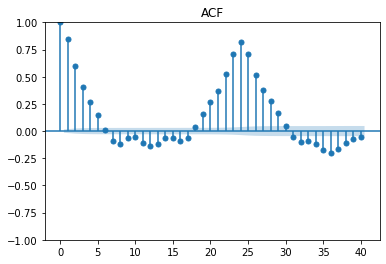

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train_model["cnt"], lags=40)
plt.title("ACF")
plt.show()

In [10]:
my_order = (1,1,0)
my_seasonal_order = (1, 1, 1, 24)
train_arima = train[:-24*3*7]
train_arima = train_arima['cnt']
test_arima = train[-24*3*7:]
test_arima = test_arima['cnt']


In [54]:
test_arima.isna().sum()

0

In [11]:
# SARIMAX op de train_set
model = SARIMAX(train_arima, order=my_order, seasonal_order = my_seasonal_order)
mf = model.fit(disp=True)

# get the predictions 
y_pred = mf.forecast(len(test_arima))
y_pred = pd.Series(y_pred, index=test_arima.index)

# scores
MSE = mean_squared_error(test_arima, y_pred)
RMSE = MSE**0.5
R2 = r2_score(test_arima, y_pred)
MAE = mean_absolute_error(test_arima, y_pred)
# Print evaluation metrics
print("Mean Squared Error (MSE):", MSE)
print("Root Mean Squared Error (RMSE):", RMSE)
print("R-squared (R2):", R2)
print("Mean Absolute Error (MAE):", MAE)

Mean Squared Error (MSE): 31824.098222451757
Root Mean Squared Error (RMSE): 178.39310026582237
R-squared (R2): 0.020960841525384466
Mean Absolute Error (MAE): 140.7211854548409


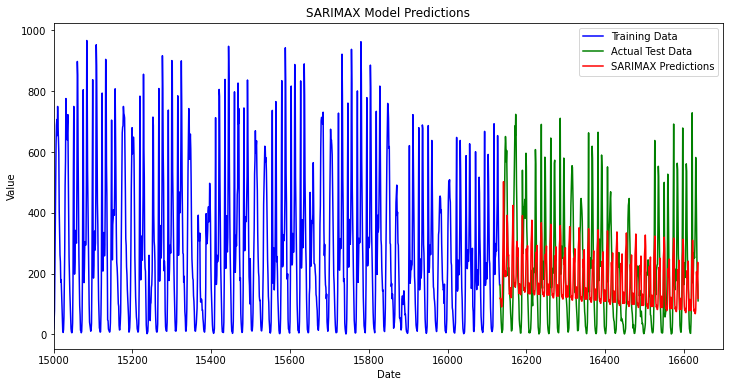

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(train_arima.index, train_arima, label='Training Data', color='blue')
plt.plot(test_arima.index, test_arima, label='Actual Test Data', color='green')
plt.plot(test_arima.index, y_pred, label='SARIMAX Predictions', color='red')
plt.title('SARIMAX Model Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xlim(15000, 16700)
plt.legend()
plt.show()

**SARIMAX**

SARIMAX is een tijdreeksmodel dat de invloed van seizoensgebondenheid, trend en externe factoren (exogeen) op een tijdreeksvariabele kan modelleren. Het model combineert het Seasonal ARIMA-model (SARIMA) met de mogelijkheid om externe voorspellende variabelen op te nemen.

**Formules**

en SARIMA-model van orde *(p,d,q)* met seizoensgebonden orde *(P,D,Q,m)* kan worden geschreven als:

*(1 − ϕ1B − ϕ2B2 −…− ϕpBp)⋅(1 − Φ1Bm − Φ2B2m −…− ΦPBPm)⋅(1 − B)d ⋅(1 − Bm) D⋅*
*Yt=*

*(1 + θ1B + θ2B2 +…+ θqBq)⋅(1 + Θ1Bm + Θ2B2m +…+ ΘQBQm)⋅ εt*

waarbij:

- *Yt* is de geobserveerde tijdreeks.
- *B* is de backshift operator *(BYt=Yt−1)*
- *ϕi* en *θi* zijn de AR- en MA-coëfficiënten van de niet-seizoensgebonden component.
- *εt* is een witte ruis (random error).

**SARIMAX met een Exogene Factoren**

SARIMAX kan worden uitgebreid om exogene factoren *Xt* op te nemen. Het model wordt dan:

*(1 − ϕ1B − ϕ2B2 −…− ϕpBp)⋅(1 − Φ1Bm − Φ2B2m −…− ΦPBPm)⋅(1 − B)d ⋅(1 − Bm) D ⋅* *Yt=*

*(1 + θ1B + θ2B2 +…+ θqBq)⋅(1 + Θ1Bm + Θ2B2m +…+ ΘQBQm) ⋅ Xt ⋅ εt*

Hier is allen de *Xt* erbij gekomen. Dit zijn de exogene variabelen op tijdstip *t*. 


**Model Implementatie**

De code die wij hebben geschreven gebruikt GridSearchCv om de beste hyperparameters voor SARIMAX te vinden, hier wordt ook de exogene variabelen meegepakt. 

**Voordelen**

SARIMAX is krachtig voor het modelleren van tijdsreeksen met seizoensgebondenheid en trend, vooral wanneer exogene factoren van invloed zijn op de tijdsreeks. 

**Bronnen voor (S)Arima(X)**

Barretto, D. P. B. (z.d.). Time Series Part 2: Forecasting with SARIMAX models: An Intro. mkbdatalab. https://www.jadsmkbdatalab.nl/forecasting-with-sarimax-Statsmodels.tsa.statespace.sarimax.SARIMAX - 

Statsmodels 0.15.0 (+73). (z.d.). https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

**Prophet**

In [41]:
X = train_ts_feature2.drop(['date_hour', 'cnt'], axis=1)
y = train_ts_feature2['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [42]:
from prophet import Prophet
prop_train = train_ts_feature2.copy()
prop_train.rename(columns={'date_hour': 'ds', 'cnt': 'y'}, inplace=True)




profeet = Prophet(changepoint_prior_scale = 0.001, seasonality_prior_scale = 0.1, seasonality_mode = 'multiplicative')
profeet.fit(prop_train)
future = profeet.make_future_dataframe(periods=len(train_ts_feature2))
forecast = profeet.predict(future)

prophet_pred_test = forecast['yhat'][-len(y_test):].values

rmse = np.sqrt(np.mean((prophet_pred_test - y_test) **2))
print(f" RMSE: {rmse}")


16:26:16 - cmdstanpy - INFO - Chain [1] start processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing


 RMSE: 1681.53999154216


**Prophet Model**

Het Prophet-model is ontworpen om tijdreeksvoorspellingen te genereren en maakt gebruik van een geavanceerde aanpak om seizoensgebondenheid en trend in de gegevens vast te leggen. Hier wordt de implementatie van het Prophet-model beschreven:

**Implementatie:**

1. Initialisatie:
Importeer de Prophet-klasse uit de prophet-bibliotheek en initialiseer een Prophet-model met specifieke configuratie-instellingen.

2. Voorbereiding van de Trainingsgegevens:
Kopieer en hernoem de trainingsgegevenskolommen naar 'ds' (datum) en 'y' (waarde) om te voldoen aan de inputvereisten van het Prophet-model.

3. Modeltraining:
Train het Prophet-model met behulp van de voorbereide trainingsgegevens.

4. Creatie van Toekomstige Data:
Maak een dataframe voor toekomstige voorspellingen met dezelfde tijdsstructuur als de trainingsgegevens.

5. Voorspellingen Uitvoeren:
Voer voorspellingen uit op het toekomstige dataframe met het getrainde Prophet-model.

6. Haal Voorspelde Waarden Op voor Testgedeelte:
Haal de voorspelde waarden op voor het testgedeelte van de dataset.

**Evaluatie:**
Bereken de Root Mean Squared Error (RMSE) als evaluatiemetric om de nauwkeurigheid van het model te meten.

1. Druk de RMSE af:
Druk de berekende RMSE af om inzicht te geven in de prestaties van het Prophet-model.

**Voordelen:**

Het Prophet-model biedt verschillende voordelen, waaronder het vermogen om goed om te gaan met seizoensgebonden patronen en de mogelijkheid om de trend in de tijdreeksgegevens vast te leggen. Het kan effectief presteren in situaties waar traditionele modellen tekort kunnen schieten, waardoor het een waardevolle tool is voor tijdreeksanalyse.







**Bronnen voor Prophet**

Prophet. (z.d.). Prophet. https://facebook.github.io/prophet/

Diagnostics. (2023, 18 oktober). Prophet. https://facebook.github.io/prophet/docs/diagnostics.html

### Hybride model

In [43]:
X = train_ts_feature2.drop(['date_hour', 'cnt'], axis=1)
y = train_ts_feature2['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Eerste model: Lineaire Regressie
lr_hm = LinearRegression(n_jobs=-1)
lr_hm.fit(X_train, y_train)

# Voorspellen van de waarden voor train en test
y_pred_lr = lr_hm.predict(X_train)
pred_test = lr_hm.predict(X_test)
residuals = y_train - y_pred_lr

# Tweede model: Decision Tree Regressor
dt_hm = DecisionTreeRegressor()

# Fit the Decision Tree model to the residuals
dt_hm.fit(X_train, residuals)

# Voorspellen van de residuals
y_pred_dt = dt_hm.predict(X_test)

# Samenvoegen van voorspellingen
y_pred = np.round(pred_test + y_pred_dt).astype(int)

MSE = mean_squared_error(y_test, y_pred)
RMSE = MSE**0.5
R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
# Print evaluation metrics
print("Mean Squared Error (MSE):", MSE)
print("Root Mean Squared Error (RMSE):", RMSE)
print("R-squared (R2):", R2)
print("Mean Absolute Error (MAE):", MAE)

Mean Squared Error (MSE): 12013.56640625
Root Mean Squared Error (RMSE): 109.60641589911606
R-squared (R2): 0.7665826674649296
Mean Absolute Error (MAE): 70.56580528846153


**Hybride**

Een hybride model combineert de sterke punten van verschillende modellen om een betere voorspelling te genereren. In dit geval gebruikt het hybride model zowel Lineaire Regressie als een Decision Tree Regressor om complementaire aspecten van beide modellen te benutten.

**Implentatie**

1. Lineaire Regressie
Lineaire Regressie wordt getraind op de trainingsgegevens *(Xtrain, ytrain)* om de lineaire relatie tussen de onafhankelijke variabelen X en de afhankelijke variabele y te modelleren.

2. Decision Tree Regressor
Een Decision Tree Regressor wordt gebruikt om de residuen (fouten) van de Lineaire Regressie op de trainingsgegevens te voorspellen.

3. Samenvoegen van Voorspellingen
De voorspellingen van Lineaire Regressie en de voorspelde residuen van de Decision Tree Regressor worden samengevoegd om de uiteindelijke voorspelling te verkrijgen.

4. Evaluatie
Het hybride model wordt geëvalueerd op de testgegevens *(Xtest,ytest)* met behulp van de Root Mean Squared Error (RMSE) als evaluatiemetric.

**Formule**

De voorspelling van het hybride model wordt gegeven door:

*Voorspelling hybride =Voorspelling Lineaire Regressie + Voorspelling Decision Tree Regressor*

**Voordelen**

Het hybride model kan synergieën tussen de modellen benutten en presteren in situaties waarin individuele modellen mogelijk tekortschieten.

**Bronnen voor Hybride**

Ryanholbrook. (2023a, april 20). Exercise: Hybrid models. Kaggle. https://www.kaggle.com/code/ryanholbrook/exercise-hybrid-models

ChatGPT: https://chat.openai.com/share/71701311-8bcc-4162-98e4-dae63f7934c0

# Conclusie & Advies

## Conclusie

**Features**

In het begin hadden wij gekeken naar de meest belovende features. Hier kwam uit dat de tijd op de dag een belangrijke rol speelt. Als het geen vakantie is dan komen de meeste verhuringen voor rond de spits. Wanneer het wel een vakantie is dan is er een piek rond de middag. 

Wat voor weer het is, is ook een belangrijke feature. Zo zagen wij dat als het weer 'clear' was, het product meer word verhuurd.  Wanneer het weer 'heavy rain' is, wordt er het minst verhuurd. 

Dit sluit goed aan op het EDA. Hier hadden wij een correlatie plot laten zien. Dit zei dat 'temp', 'atemp' en 'hour' de grootste correlatie hebben met 'cnt'. 

**Modellen**

De modellen die wij hebben gebruikt zijn Lineare Regressie, Random Forest, Decision Tree, Gradient Boosting, SVR, SARIMAX, Prophet en Hybride. Deze modellen hebben wij gemeten met RMSE, MSE, MAE en R2. Uit deze scores kwam dat Random Forest het beste scored. 

De beste parameters hiervoor zijn:  
- 'bootstrap': False
- 'max_depth': 30, 
- 'max_features': 'sqrt', 
- 'min_samples_leaf': 1, 
- 'min_samples_split': 2, 
- 'n_estimators': 150, 
- 'random_state': 42


## Advies

**Features**

Wij adviseren om meer medewerkers en producten beschikbaar te hebben rond de spits wanneer het geen vakantie is. Wanneer het wel vakantie is het beschikbaar te hebben rond de middag. Ook zal u meer producten beschikbaar hebben tijdens warmere dagen. Je kan bijvoorbeeld kortingen doen in de winter zodat er meer klanten zullen huren.  

**Modellen**

Wij adviseren om het model Random Forest te gebruiken. Deze scored het beste, dus zal beter kunnen voorspellen wanneer er een stijging is in de verhuur. 

**Kaggle scoren**

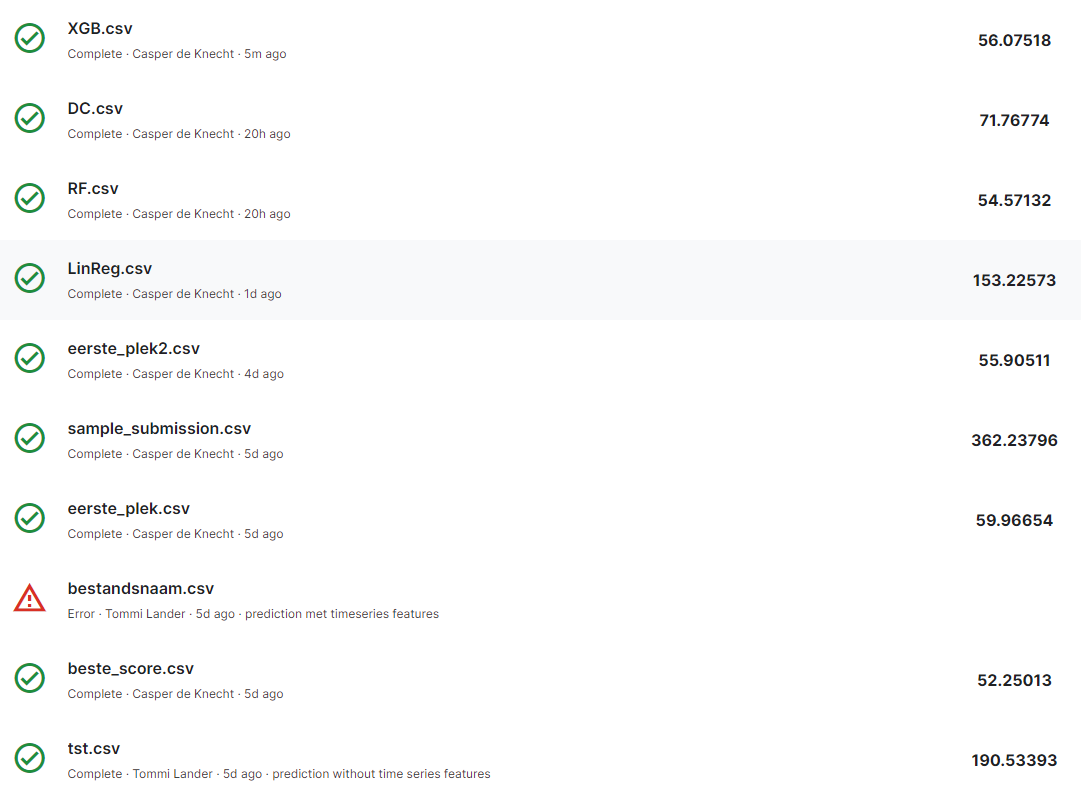


Hierboven delen we onze scores op Kaggle. Onze beste score was uiteindelijk 50, behaald met een variant van de Random Forest Regression. Helaas is deze score niet zichtbaar in de afbeelding omdat deze zich onderaan bevond. Interessant genoeg hebben we tijdens onze zoektocht naar de beste score enkele opmerkelijke ontdekkingen gedaan. We hebben bijvoorbeeld geprobeerd nieuwe functies te genereren voor het testdataframe door gebruik te maken van al voorspelde waarden van 'cnt' (aantal). Hoewel deze aanpak natuurlijke nadelen met zich meebrengt, zoals het verergeren van eventuele fouten bij de eerste voorspelling, viel het ons op dat we consistent een iets hogere score behaalden dan de oorspronkelijke score. De originele score was 50, terwijl ons experiment een score van 52 opleverde (de score van 'beste_score.csv').